#### Load Training Data

In [1]:
import os
import glob

vehicles_base_dir = 'vehicles/'
not_vehicles_base_dir = 'non-vehicles/'

def load_image_names(basedir):
    imgs = []
    for img_src in os.listdir(basedir):
        imgs.extend(glob.glob(basedir + img_src + '/*'))
    return imgs
        
cars = load_image_names(vehicles_base_dir)
not_cars = load_image_names(not_vehicles_base_dir)

print('Number of car images: ', len(cars))
print('Number of non car images: ', len(not_cars))


Number of car images:  8792
Number of non car images:  8968


#### Extract Hog Features

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
%matplotlib inline

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Return HOG features and visualization
    """
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        return  hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cell_per_block, cell_per_block), visualise=True, 
                    feature_vector=feature_vec, block_norm='L2-Hys')
    else:      
        # Use skimage.hog() to get features only
        return  hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cell_per_block, cell_per_block), visualise=False, 
                    feature_vector=feature_vec, block_norm='L2-Hys')




#### Visualize hog features

In [3]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        if len(img.shape) < 3:
            plt.imshow(img,cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])
           

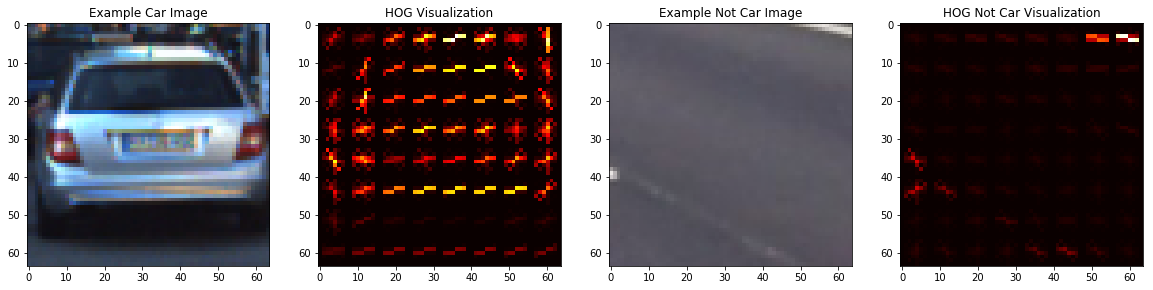

In [4]:
# Generate a random index to look at a car and non car images
ind = np.random.randint(0, len(cars))
not_car_ind = np.random.randint(0, len(not_cars))
# Read in the images
image = mpimg.imread(cars[ind])
not_car_image = mpimg.imread(not_cars[not_car_ind])

s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)[:,:,0]
not_car_s_channel = cv2.cvtColor(not_car_image, cv2.COLOR_RGB2YCrCb)[:,:,0]

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(s_channel, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features, not_car_hog_image = get_hog_features(not_car_s_channel, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(20,160))
visualize(fig, 1, 4, [image, hog_image, not_car_image, not_car_hog_image],
         ['Example Car Image','HOG Visualization','Example Not Car Image','HOG Not Car Visualization'])



#### Extract Spatially Binned Features

In [5]:
def bin_spatial(img, size=(32, 32)):
    c1 = cv2.resize(img[:,:,0], size).ravel()
    c2 = cv2.resize(img[:,:,1], size).ravel()
    c3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((c1, c2, c3))

#### Visualize Spatially Binned Feature

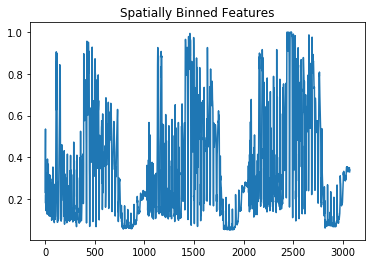

In [6]:

feature_vec = bin_spatial(image, size=(32, 32))

# Plot features
fig = plt.figure()
plt.plot(feature_vec)
plt.title('Spatially Binned Features')


#### Extract Color Histogram Features

In [7]:
# Define a function to   
def color_hist(img, nbins=32, vis=False):
    """
    Computes color histogram features
    """
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins)
    ghist = np.histogram(img[:,:,1], bins=nbins)
    bhist = np.histogram(img[:,:,2], bins=nbins)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    if vis == True:
        return rhist, ghist, bhist, bin_centers, hist_features
    return hist_features

#### Visualize Color Histogram Features

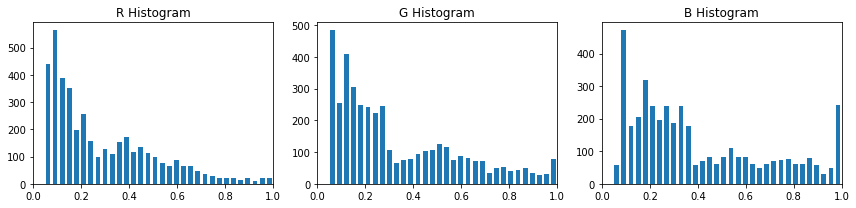

In [8]:
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, vis=True)

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0],0.02)
    plt.xlim(0, 1)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0],0.02)
    plt.xlim(0, 1)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0],0.02)
    plt.xlim(0, 1)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')


#### Extract Features

In [9]:
def extract_features(img, cspace='RGB', spatial_size=(32, 32), hist_bins=32, 
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                    spatial_feat=True, hist_feat=True, hog_feat=True, viz=False):
    # list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        img2 = cv2.cvtColor(img, eval('cv2.COLOR_RGB2' + cspace))
    else:
        img2 = np.copy(img)
    
    # Apply bin_spatial() to get spatial color features
    if spatial_feat == True:
        spat_features = bin_spatial(img2, size=spatial_size)
        features.append(spat_features)
        
    # Apply color_hist() to get color histogram features
    if hist_feat == True:
        hist_features = color_hist(img2, nbins=hist_bins)
        features.append(hist_features)
        
    # Apply get_hog_features() to get hog features
    if hog_feat == True:
        if hog_channel == 'All':
            hog_features = []
            for channel in range(img2.shape[2]):
                hog_features.append(get_hog_features(img2[:,:,channel], orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if viz == True:
                hog_features, hog_image = get_hog_features(img2[:,:,hog_channel], orient, pix_per_cell, cell_per_block,
                                             vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(img2[:,:,hog_channel], orient, pix_per_cell, cell_per_block,
                                             vis=False, feature_vec=True)
                
        features.append(hog_features)
    # Concatenate features
    if viz == True:
        return np.concatenate(features), hog_image
    else:
        return np.concatenate(features)
    
    
def extract_imgs_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, 
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                    spatial_feat=True, hist_feat=True, hog_feat=True, viz=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_name in imgs:
        # Read in each one by one
        img = mpimg.imread(img_name)
        features.append(extract_features(img, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, viz=viz))
    # Return list of feature vectors
    return features


#### Tuning feature extraction parameters

In [10]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.svm as svm

#Feature extraction parameters
cspace='YCrCb'
#cspace='HSV'
#cspace='HLS'
#cspace='YUV'
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='All'
spatial_feat=True
hist_feat=True
hog_feat=True

# Run with smaller number of samples
n = 1000
t = time.time()
r_ind = np.random.randint(0, len(cars), n)
test_cars = np.array(cars)[r_ind]
rn_ind = np.random.randint(0, len(not_cars), n)
test_notcars = np.array(not_cars)[rn_ind]

test_car_features = extract_imgs_features(test_cars, cspace=cspace, spatial_size=spatial_size,
                                     hist_bins=hist_bins, orient=orient, pix_per_cell= pix_per_cell,
                                     cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                     spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
test_notcar_features = extract_imgs_features(test_notcars, cspace=cspace, spatial_size=spatial_size,
                                     hist_bins=hist_bins, orient=orient, pix_per_cell= pix_per_cell,
                                     cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                     spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

test_features = np.vstack((test_car_features, test_notcar_features)).astype(np.float64)
test_lables = np.hstack((np.ones(n), np.zeros(n)))

print('Time to compute features: ', time.time() - t)
print('Feature vector length: ', len(test_features[0]))

test_scaler = StandardScaler().fit(test_features)
scaled_test_features = test_scaler.transform(test_features)

# split into a training and testing set
reandom_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_test_features, test_lables, 
                                                    test_size=0.1, random_state=reandom_state)
# tuning the classifier parameters
clf = svm.LinearSVC()
t = time.time()
clf.fit(X_train, y_train)
print ('Time to fit classifier: ', time.time() - t)
print('Test accuracy of the choosen SVC: ', round(clf.score(X_test, y_test), 4))


Time to compute features:  13.799043893814087
Feature vector length:  8460
Time to fit classifier:  5.115365982055664
Test accuracy of the choosen SVC:  0.975


#### Choose classifier and train on full data set

In [11]:
#Extract features from the full data set
t = time.time()
car_features = extract_imgs_features(cars, cspace=cspace, spatial_size=spatial_size,
                                     hist_bins=hist_bins, orient=orient, pix_per_cell= pix_per_cell,
                                     cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_imgs_features(not_cars, cspace=cspace, spatial_size=spatial_size,
                                     hist_bins=hist_bins, orient=orient, pix_per_cell= pix_per_cell,
                                     cell_per_block=cell_per_block, hog_channel=hog_channel)

features = np.vstack((car_features, notcar_features)).astype(np.float64)
lables = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

scaler = StandardScaler().fit(features)
scaled_features = test_scaler.transform(features)

print('Time to compute features: ', time.time() - t)
print('Feature vector length: ', len(test_features[0]))

# split into a training and testing set
reandom_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, lables, 
                                                    test_size=0.1, random_state=reandom_state)

# Use grid search to choose the best classifier parameters
#
# Commented out because of poor performance by the recommended 
# best parameters: {'kernel': 'rbf', 'C': 1.0}
#

#parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 0.5, 1.0]}
#svc = svm.SVC()
#clf = GridSearchCV(svc, parameters)

#
# Use linear classifier instead
#
clf = svm.LinearSVC()

t = time.time()
clf.fit(X_train, y_train)
print ('Time to choose/fit classifier: ', time.time() - t)
#print('Best estimator: ', clf.best_estimator_)
#print('Best parameters: ', clf.best_params_)
print('Test accuracy of the choosen SVC: ', round(clf.score(X_test, y_test), 4))


Time to compute features:  125.34059596061707
Feature vector length:  8460
Time to choose/fit classifier:  21.801236867904663
Test accuracy of the choosen SVC:  0.9893


#### Visualize Features

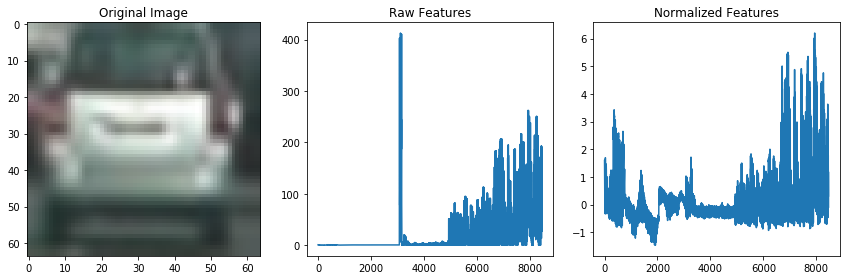

In [12]:

if len(features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, 500)
    not_car_ind = np.random.randint(0, 500)
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')



#### Window functions

In [13]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Draws boxes over provided image.
    Parameters:
    `img` - image to draw boxes over
    `boxes` - list of box coordinates
    `color` - color to draw with
    `thick` - line thickness
    
    Retuns:
    copy of the image with boxes drwawn over
    """
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Generates a list of overlaping windows.
    Parameters:
    `img` - image to slide window over
    `x_start_stop`, `y_start_stop` - area of image to slide window
    `xy_window` - window size
    `xy_overlap` - overlap by x and y (0,1.0)
    """
    # If x and/or y start/stop positions not defined, set to image size
    x_start, x_stop = x_start_stop
    if x_start == None:
        x_start = 0
    if x_stop == None:
        x_stop = img.shape[1]
    y_start, y_stop = y_start_stop
    if y_start == None:
        y_start = 0
    if y_stop == None:
        y_stop = img.shape[0]
    # Compute the span of the region to be searched    
    x_span = x_stop - x_start
    y_span = y_stop - y_start
    # Compute the number of pixels per step in x/y
    x_step = int(xy_window[0] * xy_overlap[0])
    y_step = int(xy_window[1] * xy_overlap[1])
    # Compute the number of windows in x/y
    nx = (x_span - xy_window[0]) / x_step
    ny = (y_span - xy_window[1]) / y_step
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for x in range(x_start, x_stop - xy_window[0]+1, x_step):
        for y in range(y_start, y_stop - xy_window[1]+1, y_step):
            window_list.append(((x,y),(x+xy_window[0], y + xy_window[1])))
    return window_list

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    orient=9, pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
    Returns a list of windows with positive car detection
    """

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    


#### Test search on test images

Time to process image:  1.9485759735107422 Windows:  350
Time to process image:  1.883711814880371 Windows:  350
Time to process image:  1.867676019668579 Windows:  350
Time to process image:  1.9148988723754883 Windows:  350
Time to process image:  1.8956921100616455 Windows:  350
Time to process image:  1.8793308734893799 Windows:  350


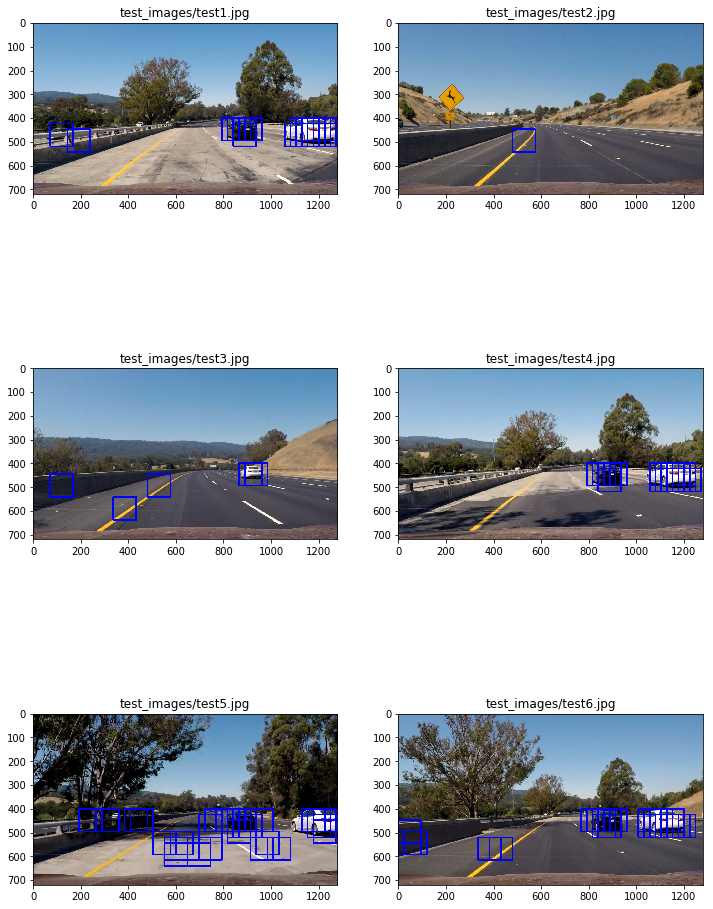

In [14]:
spatial_feat=True
hist_feat=True
hog_feat=True
test_images = glob.glob('test_images/*.jpg')    
y_start_stop = [400, 656]
images = []
for img_src in test_images:
    # Check the prediction time for a single sample
    t=time.time()

    image = mpimg.imread(img_src)
    draw_image = np.copy(image)

    # image is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.25, 0.25))

    hot_windows = search_windows(image, windows, clf, scaler, color_space=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    images.append(window_img)
    
    print('Time to process image: ', time.time() - t, 'Windows: ', len(windows))

fig = plt.figure(figsize=(12,18))
visualize(fig, 3, 2, images, test_images)



#### Subsampling hog features

In [15]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    

def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell,
              cell_per_block, spatial_size, hist_bins):
    """
    Extracts features using hog sub-sampling and make predictions
    """
    window_list = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    for scale in scales:
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2
    
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1).astype(np.float64))    
                test_prediction = svc.predict(test_features)
            
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return window_list


#### Heat map

In [16]:
n_frames = 15

def add_heat(recent_heatmap, bbox_list, img_size):
    heat = np.zeros(img_size).astype(np.float)

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    if len(recent_heatmap) == 0:
        recent_heatmap = [heat]
    elif len(recent_heatmap) < n_frames:
        recent_heatmap = np.vstack((recent_heatmap,heat))
    else:
        recent_heatmap = np.roll(recent_heatmap, -1, axis=0)
        recent_heatmap[n_frames - 1] = heat
        
    # Return sum of heatmap
    return np.sum(recent_heatmap, axis=0)
    


#### Visualize subsampling search and heat map

Time to process image:  1.6233668327331543
Time to process image:  1.5226349830627441
Time to process image:  1.4686269760131836
Time to process image:  1.4584829807281494
Time to process image:  1.4748690128326416
Time to process image:  1.5307810306549072


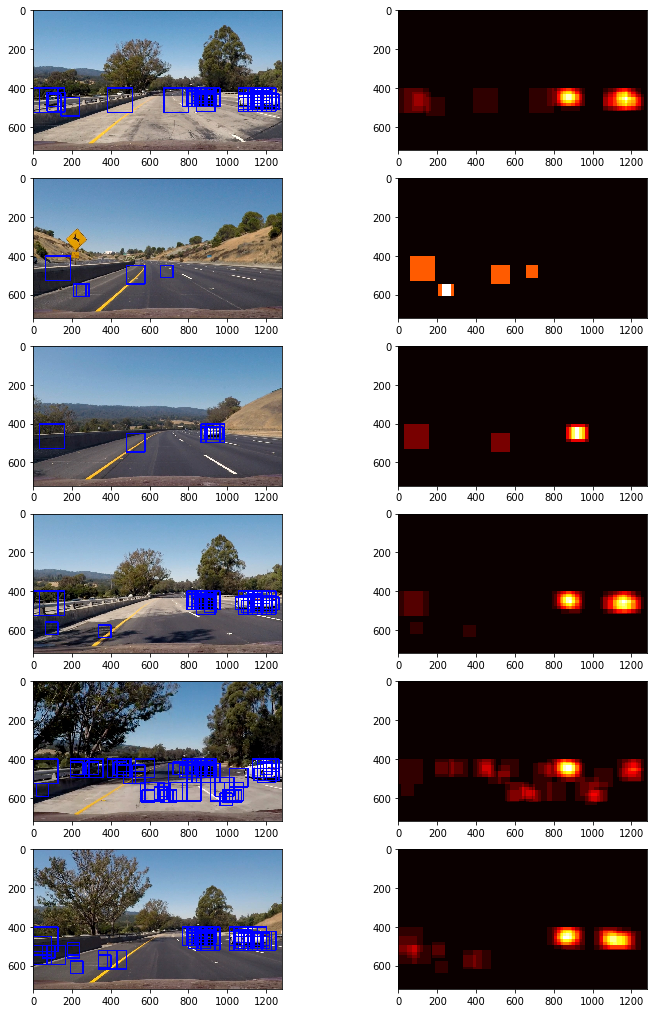

In [17]:
ystart = 400
ystop = 656
scales = [1.0, 1.5, 2.0]
images = []
titles = []
for img_src in test_images:
    t=time.time()

    img = mpimg.imread(img_src)
    draw_image = np.copy(img)

    box_list = find_cars(img, ystart, ystop, scales, clf, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    recent_heatmap = []
    heat = add_heat(recent_heatmap, box_list, img[:,:,0].shape)
    images.append(draw_boxes(draw_image, box_list))
    images.append(heat)
    titles.append('')
    titles.append('')
    print('Time to process image: ', time.time() - t)
          
fig = plt.figure(figsize=(12,18))
visualize(fig, 6, 2, images, titles)


#### Heat threshold and labeled boxes

In [18]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


#### Visualize heat threshold and labeled boxes

Time to process image:  1.4819471836090088
Time to process image:  1.4922258853912354
Time to process image:  1.6238970756530762
Time to process image:  1.602391004562378
Time to process image:  1.6070239543914795
Time to process image:  1.5846610069274902


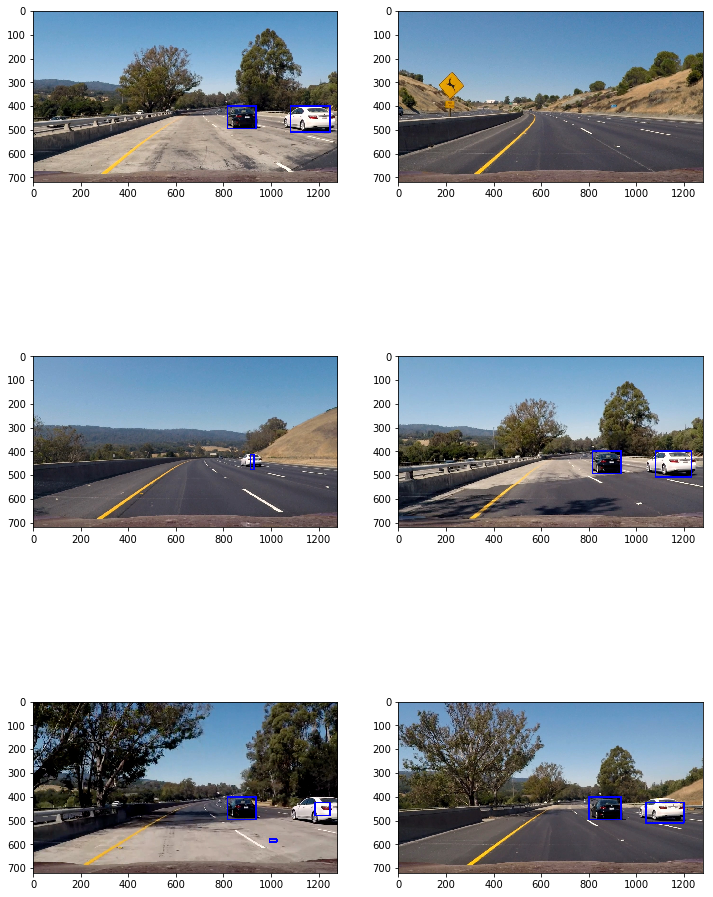

In [19]:
images = []
titles = []
for img_src in test_images:
    t=time.time()

    img = mpimg.imread(img_src)
    draw_image = np.copy(img)

    box_list = find_cars(img, ystart, ystop, scales, clf, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    recent_heatmap = []
    heat = add_heat(recent_heatmap, box_list, img[:,:,0].shape)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    images.append(draw_img)
    titles.append('')
    print('Time to process image: ', time.time() - t)
          
fig = plt.figure(figsize=(12,18))
visualize(fig, 3, 2, images, titles)


#### Video Pipeline

In [23]:
recent_heatmap = []

def process_image(img):
    global recent_heatmap
    box_list = find_cars(img, ystart, ystop, scales, clf, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = add_heat(recent_heatmap, box_list, img[:,:,0].shape)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,6)
    
    # Find final boxes from heatmap using label function
    labels = label(heat)
    return draw_labeled_bboxes(np.copy(img), labels)
   

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

recent_heatmap = []

test_output = 'test.mp4'
#clip = VideoFileClip('test_video.mp4')
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [31:21<00:01,  1.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



In [25]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))